In [1]:
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA 
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import math

from credit_risk import CreditRisk

In [2]:
df = pd.read_csv("sample_orig_2020.csv", sep="|", header=None, usecols=[0,5,7,8,9,10,12,16], names=['CreditScore', 'InsurancePercentage', 'Occupancy', 'LTV', 'DebtToIncome', 'MortgageValue', 'InterestRate', 'PropertyState']) 

In [3]:
print(df.describe())

        CreditScore  InsurancePercentage           LTV  DebtToIncome  \
count  25000.000000         25000.000000  25000.000000   25000.00000   
mean     756.590560             5.556360     71.836520      33.78228   
std       71.999272            10.701426     16.719426      11.47428   
min      601.000000             0.000000      7.000000       1.00000   
25%      729.000000             0.000000     61.000000      26.00000   
50%      765.000000             0.000000     75.000000      35.00000   
75%      790.000000             0.000000     80.000000      42.00000   
max     9999.000000            35.000000    104.000000     999.00000   

       MortgageValue  InterestRate  
count   2.500000e+04  25000.000000  
mean    2.775571e+05      3.477088  
std     1.374680e+05      0.491951  
min     2.200000e+04      2.250000  
25%     1.740000e+05      3.125000  
50%     2.540000e+05      3.375000  
75%     3.600000e+05      3.750000  
max     1.280000e+06      6.375000  


In [4]:
#Removing outliers
df = df[df["CreditScore"]<=1000]
df = df[df["DebtToIncome"]<=100]

In [5]:
df.head()

CreditScore  InsurancePercentage Occupancy  LTV  DebtToIncome  \
0          695                   12         P   85            34   
1          781                    0         P   67            44   
2          682                    0         P   62            43   
3          811                   12         P   88            27   
4          754                    0         P   80            25   

   MortgageValue  InterestRate PropertyState  
0         460000         3.875            CA  
1         142000         3.250            MI  
2         136000         4.000            WY  
3         138000         3.125            NE  
4         252000         3.750            IL

In [6]:
lim_df = df[['CreditScore', 'InsurancePercentage', 'LTV', 'DebtToIncome', 'MortgageValue', 'InterestRate']]

In [7]:
lim_df.head()

CreditScore  InsurancePercentage  LTV  DebtToIncome  MortgageValue  \
0          695                   12   85            34         460000   
1          781                    0   67            44         142000   
2          682                    0   62            43         136000   
3          811                   12   88            27         138000   
4          754                    0   80            25         252000   

   InterestRate  
0         3.875  
1         3.250  
2         4.000  
3         3.125  
4         3.750

<AxesSubplot:>

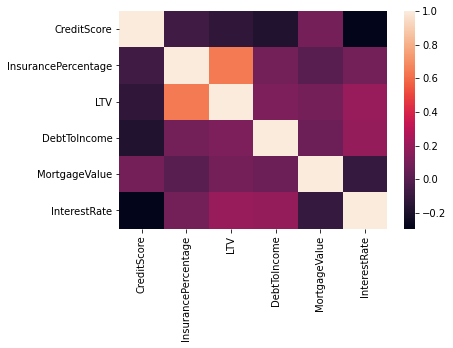

In [8]:
sns.heatmap(lim_df.corr())


<AxesSubplot:>

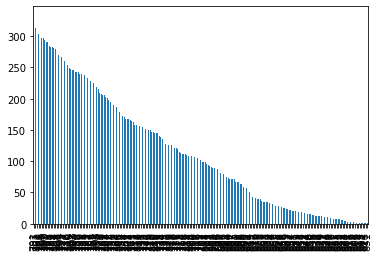

In [9]:
lim_df['CreditScore'].value_counts().plot(kind='bar')


In [10]:
# First we create bins for data

bins = 12
labels = [0.01, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44]

lim_df['DebtToIncomeBins'] =  pd.cut(lim_df['DebtToIncome'], bins, labels=labels, precision=8).astype("float")
lim_df['LTVBins'] =  pd.cut(lim_df['LTV'], bins, labels=labels, precision=8).astype("float")
lim_df['CreditScoreBins'] =  pd.cut(lim_df['CreditScore'], bins, labels=labels, precision=8).astype("float")

lim_df['TotalSensitivity'] = lim_df['LTVBins'] * lim_df['DebtToIncomeBins'] * (1-lim_df['InsurancePercentage']/100) * 10
lim_df['DefaultProbability'] = lim_df['CreditScoreBins'] * (1-lim_df['InsurancePercentage']/100)
lim_df['LGD'] = lim_df['MortgageValue'] * (1-lim_df['InsurancePercentage']/100)
lim_df.head(20)

<ipython-input-10-7a6062208475>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lim_df['DebtToIncomeBins'] =  pd.cut(lim_df['DebtToIncome'], bins, labels=labels, precision=8).astype("float")


CreditScore  InsurancePercentage  LTV  DebtToIncome  MortgageValue  \
0           695                   12   85            34         460000   
1           781                    0   67            44         142000   
2           682                    0   62            43         136000   
3           811                   12   88            27         138000   
4           754                    0   80            25         252000   
5           763                    0   52            20         134000   
6           780                    0   80            28         230000   
7           742                    0   41            26         155000   
8           787                   25   95            17          71000   
9           708                   25   90            45          63000   
10          743                    0   59            36         290000   
11          724                    0   70            31          59000   
12          708                    0   74            43         125000   
13          790                    6   84            23          78000   
14          722                    0   51            26          51000   
15          769                   30   92            50         189000   
16          791                    0   70            35         338000   
17          748                    0   80            37         423000   
18          735                    0   80            46          84000   
19          733                    0   67            16         100000   

    InterestRate  DebtToIncomeBins  LTVBins  CreditScoreBins  \
0          3.875              0.32     0.36             0.16   
1          3.250              0.40     0.28             0.36   
2          4.000              0.40     0.24             0.16   
3          3.125              0.24     0.40             0.40   
4          3.750              0.20     0.36             0.28   
5          2.875              0.16     0.20             0.32   
6          4.000              0.24     0.36             0.36   
7          3.125              0.24     0.16             0.28   
8          3.000              0.12     0.40             0.36   
9          4.375              0.40     0.40             0.20   
10         3.750              0.32     0.24             0.28   
11         4.000              0.28     0.28             0.24   
12         3.750              0.40     0.32             0.20   
13         3.500              0.20     0.36             0.36   
14         3.000              0.24     0.20             0.24   
15         3.750              0.44     0.40             0.32   
16         3.125              0.32     0.28             0.36   
17         3.750              0.32     0.36             0.28   
18         3.750              0.44     0.36             0.24   
19         3.875              0.12     0.28             0.24   

    TotalSensitivity  DefaultProbability       LGD  
0            1.01376              0.1408  404800.0  
1            1.12000              0.3600  142000.0  
2            0.96000              0.1600  136000.0  
3            0.84480              0.3520  121440.0  
4            0.72000              0.2800  252000.0  
5            0.32000              0.3200  134000.0  
6            0.86400              0.3600  230000.0  
7            0.38400              0.2800  155000.0  
8            0.36000              0.2700   53250.0  
9            1.20000              0.1500   47250.0  
10           0.76800              0.2800  290000.0  
11           0.78400              0.2400   59000.0  
12           1.28000              0.2000  125000.0  
13           0.67680              0.3384   73320.0  
14           0.48000              0.2400   51000.0  
15           1.23200              0.2240  132300.0  
16           0.89600              0.3600  338000.0  
17           1.15200              0.2800  423000.0  
18           1.58400              0.2400   84000.0  
19           0.33600              0.2400  10

In [11]:
# Create bucket by equal loan distribution

lim_df['loan_cumsum'] = lim_df.LGD.cumsum()
no_buckets = bins
bucket_size = lim_df.loan_cumsum.max() / no_buckets
lim_df['final_bucket'] = (lim_df.loan_cumsum / bucket_size).apply(math.ceil)
lim_df.describe()

CreditScore  InsurancePercentage           LTV  DebtToIncome  \
count  24998.000000         24998.000000  24998.000000  24998.000000   
mean     756.219378             5.556805     71.838027     33.744060   
std       42.033602            10.701739     16.718555      9.715661   
min      601.000000             0.000000      7.000000      1.000000   
25%      729.000000             0.000000     61.000000     26.250000   
50%      765.000000             0.000000     75.000000     35.000000   
75%      790.000000             0.000000     80.000000     42.000000   
max      831.000000            35.000000    104.000000     50.000000   

       MortgageValue  InterestRate  DebtToIncomeBins       LTVBins  \
count   2.499800e+04  24998.000000      24998.000000  24998.000000   
mean    2.775522e+05      3.477051          0.301330      0.302959   
std     1.374559e+05      0.491928          0.096187      0.084137   
min     2.200000e+04      2.250000          0.010000      0.010000   
25%     1.740000e+05      3.125000          0.240000      0.240000   
50%     2.540000e+05      3.375000          0.320000      0.320000   
75%     3.600000e+05      3.750000          0.400000      0.360000   
max     1.280000e+06      6.375000          0.440000      0.440000   

       CreditScoreBins  TotalSensitivity  DefaultProbability           LGD  \
count     24998.000000      24998.000000        24998.000000  2.499800e+04   
mean          0.303963          0.851996            0.287765  2.619974e+05   
std           0.088437          0.350068            0.092583  1.349080e+05   
min           0.010000          0.008000            0.007500  2.200000e+04   
25%           0.240000          0.576000            0.224000  1.605000e+05   
50%           0.320000          0.864000            0.300000  2.370000e+05   
75%           0.360000          1.120000            0.360000  3.390000e+05   
max           0.440000          1.760000            0.440000  1.280000e+06   

        loan_cumsum  final_bucket  
count  2.499800e+04  24998.000000  
mean   3.199455e+09      6.362149  
std    1.905285e+09      3.475841  
min    4.048000e+05      1.000000  
25%    1.514579e+09      3.000000  
50%    3.193741e+09      6.000000  
75%    4.836774e+09      9.000000  
max    6.549411e+09     12.000000

In [12]:
fig = px.scatter_matrix(lim_df, dimensions=['CreditScoreBins', 'LTVBins', 'DebtToIncomeBins', 'LGD', 'InterestRate'], labels={col:col.replace('_', ' ') for col in lim_df.columns}, height=900, color="DefaultProbability", color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

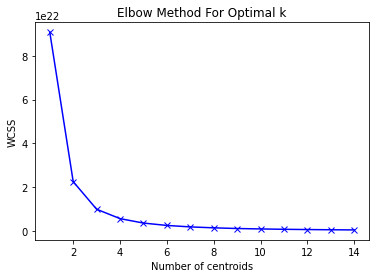

In [13]:
wcss = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(lim_df)
    wcss.append(km.inertia_)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of centroids')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

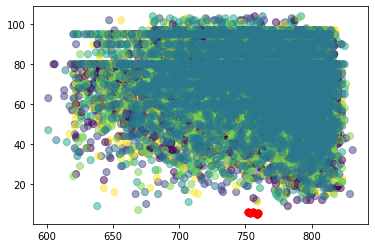

In [14]:
#converting our projected array to pandas df
#pca=pd.DataFrame(lim_df)
#pca.columns=['First component','Second Component']
#build our algorithm with k=3, train it on pca and make predictions
kmeans = KMeans(n_clusters=6, random_state=0).fit(lim_df)
y_kmeans = kmeans.predict(lim_df)
#plotting the results 
plt.scatter(lim_df['CreditScore'], lim_df['LTV'], c=y_kmeans, s=50, alpha=0.5,cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=50)

In [15]:
lim_df['cluster'] = y_kmeans
lim_df.head(20)

CreditScore  InsurancePercentage  LTV  DebtToIncome  MortgageValue  \
0           695                   12   85            34         460000   
1           781                    0   67            44         142000   
2           682                    0   62            43         136000   
3           811                   12   88            27         138000   
4           754                    0   80            25         252000   
5           763                    0   52            20         134000   
6           780                    0   80            28         230000   
7           742                    0   41            26         155000   
8           787                   25   95            17          71000   
9           708                   25   90            45          63000   
10          743                    0   59            36         290000   
11          724                    0   70            31          59000   
12          708                    0   74            43         125000   
13          790                    6   84            23          78000   
14          722                    0   51            26          51000   
15          769                   30   92            50         189000   
16          791                    0   70            35         338000   
17          748                    0   80            37         423000   
18          735                    0   80            46          84000   
19          733                    0   67            16         100000   

    InterestRate  DebtToIncomeBins  LTVBins  CreditScoreBins  \
0          3.875              0.32     0.36             0.16   
1          3.250              0.40     0.28             0.36   
2          4.000              0.40     0.24             0.16   
3          3.125              0.24     0.40             0.40   
4          3.750              0.20     0.36             0.28   
5          2.875              0.16     0.20             0.32   
6          4.000              0.24     0.36             0.36   
7          3.125              0.24     0.16             0.28   
8          3.000              0.12     0.40             0.36   
9          4.375              0.40     0.40             0.20   
10         3.750              0.32     0.24             0.28   
11         4.000              0.28     0.28             0.24   
12         3.750              0.40     0.32             0.20   
13         3.500              0.20     0.36             0.36   
14         3.000              0.24     0.20             0.24   
15         3.750              0.44     0.40             0.32   
16         3.125              0.32     0.28             0.36   
17         3.750              0.32     0.36             0.28   
18         3.750              0.44     0.36             0.24   
19         3.875              0.12     0.28             0.24   

    TotalSensitivity  DefaultProbability       LGD  loan_cumsum  final_bucket  \
0            1.01376              0.1408  404800.0     404800.0             1   
1            1.12000              0.3600  142000.0     546800.0             1   
2            0.96000              0.1600  136000.0     682800.0             1   
3            0.84480              0.3520  121440.0     804240.0             1   
4            0.72000              0.2800  252000.0    1056240.0             1   
5            0.32000              0.3200  134000.0    1190240.0             1   
6            0.86400              0.3600  230000.0    1420240.0             1   
7            0.38400              0.2800  155000.0    1575240.0             1   
8            0.36000              0.2700   53250.0    1628490.0             1   
9            1.20000              0.1500   47250.0    1675740.0             1   
10           0.76800              0.2800  290000.0    1965740.0             1   
11           0.78400              0.2400   59000.0    2024740.0             1   
12           1.28000              0.2000  125000.0 

In [16]:
for i in labels:
    print("--------")
    print("Credit Score Bin: ",i)
    print("Total LGD: {0:12,.0f} $".format(lim_df.loc[lim_df['CreditScoreBins'] == i, 'LGD'].sum()))
    print("Average Credit Score: ", lim_df.loc[lim_df['CreditScoreBins'] == i, 'CreditScore'].mean())
    print("Default Probability: ", lim_df.loc[lim_df['CreditScoreBins'] == i, 'DefaultProbability'].mean())
    print("Sensitivity: ", lim_df.loc[lim_df['CreditScoreBins'] == i, 'TotalSensitivity'].mean())

--------
Credit Score Bin:  0.01
Total LGD:    3,791,590 $
Average Credit Score:  614.8181818181819
Default Probability:  0.009813636363636365
Sensitivity:  0.8738181818181819
--------
Credit Score Bin:  0.04
Total LGD:   42,853,990 $
Average Credit Score:  630.3137254901961
Default Probability:  0.03896078431372548
Sensitivity:  0.8554635294117648
--------
Credit Score Bin:  0.08
Total LGD:   79,575,470 $
Average Credit Score:  649.7054054054054
Default Probability:  0.07627243243243242
Sensitivity:  0.8983148108108109
--------
Credit Score Bin:  0.12
Total LGD:  156,903,570 $
Average Credit Score:  668.5847953216374
Default Probability:  0.11526491228070175
Sensitivity:  0.913819649122807
--------
Credit Score Bin:  0.16
Total LGD:  313,933,170 $
Average Credit Score:  687.5806451612904
Default Probability:  0.14980175953079178
Sensitivity:  0.9551140175953079
--------
Credit Score Bin:  0.2
Total LGD:  495,001,560 $
Average Credit Score:  706.9778215869886
Default Probability:  0.18

In [17]:
loans = []
for i in range(bins):
    i=i+1
    print("--------")
    print("Credit Score Bin: ",i)
    print("Total LGD: {0:12,.0f} $".format(lim_df.loc[lim_df['final_bucket'] == i, 'LGD'].sum()))
    print("Average Credit Score: ", lim_df.loc[lim_df['final_bucket'] == i, 'CreditScore'].mean())
    print("Default Probability: ", lim_df.loc[lim_df['final_bucket'] == i, 'DefaultProbability'].mean())
    print("Sensitivity: ", lim_df.loc[lim_df['final_bucket'] == i, 'TotalSensitivity'].mean())

    loans.append([lim_df.loc[lim_df['final_bucket'] == i, 'DefaultProbability'].mean(), 
                  lim_df.loc[lim_df['final_bucket'] == i, 'TotalSensitivity'].mean(),
                  lim_df.loc[lim_df['final_bucket'] == i, 'LGD'].sum()])

print(loans)

--------
Credit Score Bin:  1
Total LGD:  545,654,620 $
Average Credit Score:  752.4858879722102
Default Probability:  0.2784460269214068
Sensitivity:  0.8882551801997395
--------
Credit Score Bin:  2
Total LGD:  545,472,030 $
Average Credit Score:  751.4186666666667
Default Probability:  0.27573084444444446
Sensitivity:  0.9033825422222223
--------
Credit Score Bin:  3
Total LGD:  546,031,980 $
Average Credit Score:  752.7163836622303
Default Probability:  0.28038256080770996
Sensitivity:  0.8815066727856816
--------
Credit Score Bin:  4
Total LGD:  545,919,330 $
Average Credit Score:  753.0367428003972
Default Probability:  0.2813110228401192
Sensitivity:  0.8954670109235352
--------
Credit Score Bin:  5
Total LGD:  545,823,970 $
Average Credit Score:  755.9786614936954
Default Probability:  0.2871778855480117
Sensitivity:  0.8679887487875849
--------
Credit Score Bin:  6
Total LGD:  545,722,790 $
Average Credit Score:  757.4457420924574
Default Probability:  0.29041673965936743
Sens

In [23]:
len(loans)

12

In [22]:
alpha = 0.03
cr = CreditRisk()
classical_var, classical_cvar = cr.classical_run(alpha, loans)
print('Montecarlo Value at Risk VaR[L]: $ {0:12,.0f}'.format(classical_var))
print('Montecarlo Conditional Value at Risk CVaR[L]: $ {0:12,.0f}'.format(classical_cvar))

ibmqfactory.load_account:WARNING:2021-05-04 10:44:33,974: Credentials are already in use. The existing account in the session will be replaced.
Montecarlo Value at Risk VaR[L]: $ 3,819,840,530
Montecarlo Conditional Value at Risk CVaR[L]: $ 5,720,885,776


In [25]:
cr.run(alpha, loans, noise=False, device="ibm_simulator")

[[0.2784460269214068, 0.8882551801997395, 545654620.0], [0.27573084444444446, 0.9033825422222223, 545472030.0], [0.28038256080770996, 0.8815066727856816, 546031980.0], [0.2813110228401192, 0.8954670109235352, 545919330.0], [0.2871778855480117, 0.8679887487875849, 545823970.0], [0.29041673965936743, 0.8271099172749392, 545722790.0], [0.28990757205666834, 0.8319701416707378, 545641530.0], [0.2950439453125, 0.82896875, 545863640.0], [0.2942923897237033, 0.8166628017450316, 545804300.0], [0.2946785750125439, 0.8390507576517813, 545739440.0], [0.2960261798310978, 0.820557178340785, 545564040.0], [0.29295403348554033, 0.8100497209538307, 546173820.0]]
[5, 5, 5, 10, 10, 10, 10, 15, 15, 15, 10, 10, 10, 5, 5, 10, 15, 5, 15, 15, 5, 25, 10, 10, 10, 15, 20, 20, 20, 15, 20, 20, 25, 10, 10, 15, 10, 15, 10, 15, 10, 25, 15, 20, 15, 25, 20, 15, 10, 10, 10, 15, 20, 15, 15, 10, 20, 15, 10, 20, 10, 15, 20, 20, 5, 20, 20, 15, 30, 25, 20, 30, 25, 35, 10, 10, 15, 15, 20, 15, 20, 10, 20, 15, 10, 10, 25, 30, 1

# Different clustering method

In [26]:
## Try ordering first and clustering later
lim_df.sort_values('CreditScore')
# Create bucket by equal loan distribution

bins = 6
labels = [0.01, 0.04, 0.08, 0.12, 0.16, 0.20] #, 0.24, 0.28, 0.32, 0.36, 0.4, 0.44]

lim_df['loan_cumsum'] = lim_df.LGD.cumsum()
no_buckets = bins
bucket_size = lim_df.loan_cumsum.max() / no_buckets
lim_df['final_bucket'] = (lim_df.loan_cumsum / bucket_size).apply(math.ceil)

lim_df['DebtToIncomeBins'] =  pd.cut(lim_df['DebtToIncome'], bins, labels=labels, precision=8).astype("float")
lim_df['LTVBins'] =  pd.cut(lim_df['LTV'], bins, labels=labels, precision=8).astype("float")
lim_df['CreditScoreBins'] =  pd.cut(lim_df['CreditScore'], bins, labels=labels, precision=8).astype("float")

lim_df['TotalSensitivity'] = lim_df['LTVBins'] * lim_df['DebtToIncomeBins'] * (1-lim_df['InsurancePercentage']/100) * 10
lim_df['DefaultProbability'] = lim_df['CreditScoreBins'] * (1-lim_df['InsurancePercentage']/100)
lim_df['LGD'] = lim_df['MortgageValue'] * (1-lim_df['InsurancePercentage']/100)

lim_df.describe()

CreditScore  InsurancePercentage           LTV  DebtToIncome  \
count  24998.000000         24998.000000  24998.000000  24998.000000   
mean     756.219378             5.556805     71.838027     33.744060   
std       42.033602            10.701739     16.718555      9.715661   
min      601.000000             0.000000      7.000000      1.000000   
25%      729.000000             0.000000     61.000000     26.250000   
50%      765.000000             0.000000     75.000000     35.000000   
75%      790.000000             0.000000     80.000000     42.000000   
max      831.000000            35.000000    104.000000     50.000000   

       MortgageValue  InterestRate  DebtToIncomeBins       LTVBins  \
count   2.499800e+04  24998.000000      24998.000000  24998.000000   
mean    2.775522e+05      3.477051          0.140478      0.141953   
std     1.374559e+05      0.491928          0.048345      0.043489   
min     2.200000e+04      2.250000          0.010000      0.010000   
25%     1.740000e+05      3.125000          0.120000      0.120000   
50%     2.540000e+05      3.375000          0.160000      0.160000   
75%     3.600000e+05      3.750000          0.200000      0.160000   
max     1.280000e+06      6.375000          0.200000      0.200000   

       CreditScoreBins  TotalSensitivity  DefaultProbability           LGD  \
count     24998.000000      24998.000000        24998.000000  2.499800e+04   
mean          0.142447          0.185820            0.134883  2.619974e+05   
std           0.045603          0.082532            0.047118  1.349080e+05   
min           0.010000          0.001000            0.007000  2.200000e+04   
25%           0.120000          0.128000            0.105600  1.605000e+05   
50%           0.160000          0.192000            0.140800  2.370000e+05   
75%           0.160000          0.256000            0.160000  3.390000e+05   
max           0.200000          0.400000            0.200000  1.280000e+06   

        loan_cumsum  final_bucket       cluster  
count  2.499800e+04  24998.000000  24998.000000  
mean   3.199455e+09      3.434435      2.474758  
std    1.905285e+09      1.718964      1.710349  
min    4.048000e+05      1.000000      0.000000  
25%    1.514579e+09      2.000000      1.000000  
50%    3.193741e+09      3.000000      2.000000  
75%    4.836774e+09      5.000000      4.000000  
max    6.549411e+09      6.000000      5.000000

In [27]:
loans = []
for i in range(bins):
    i=i+1
    print("--------")
    print("Credit Score Bin: ",i)
    print("Total LGD: {0:12,.0f} $".format(lim_df.loc[lim_df['final_bucket'] == i, 'LGD'].sum()))
    print("Average Credit Score: ", lim_df.loc[lim_df['final_bucket'] == i, 'CreditScore'].mean())
    print("Default Probability: ", lim_df.loc[lim_df['final_bucket'] == i, 'DefaultProbability'].mean())
    print("Sensitivity: ", lim_df.loc[lim_df['final_bucket'] == i, 'TotalSensitivity'].mean())

    loans.append([lim_df.loc[lim_df['final_bucket'] == i, 'DefaultProbability'].mean(), 
                  lim_df.loc[lim_df['final_bucket'] == i, 'TotalSensitivity'].mean(),
                  lim_df.loc[lim_df['final_bucket'] == i, 'LGD'].sum()])

print(loans)

--------
Credit Score Bin:  1
Total LGD: 1,091,126,650 $
Average Credit Score:  751.958488908412
Default Probability:  0.12962872831100375
Sensitivity:  0.19590233252800354
--------
Credit Score Bin:  2
Total LGD: 1,091,951,310 $
Average Credit Score:  752.8702599570713
Default Probability:  0.13108201764846172
Sensitivity:  0.19432047698545193
--------
Credit Score Bin:  3
Total LGD: 1,091,546,760 $
Average Credit Score:  756.7109545785767
Default Probability:  0.13529142579548217
Sensitivity:  0.18531019674520283
--------
Credit Score Bin:  4
Total LGD: 1,091,505,170 $
Average Credit Score:  758.3343101343102
Default Probability:  0.13748363858363857
Sensitivity:  0.1806556678876679
--------
Credit Score Bin:  5
Total LGD: 1,091,543,740 $
Average Credit Score:  758.7916666666666
Default Probability:  0.13831479289940826
Sensitivity:  0.17985376725838267
--------
Credit Score Bin:  6
Total LGD: 1,091,737,860 $
Average Credit Score:  759.3130020080321
Default Probability:  0.1383006275

In [28]:
classical_var, classical_cvar = cr.classical_run(alpha, loans)
print('Montecarlo Value at Risk VaR[L]: $ {0:12,.0f}'.format(classical_var))
print('Montecarlo Conditional Value at Risk CVaR[L]: $ {0:12,.0f}'.format(classical_cvar))

Montecarlo Value at Risk VaR[L]: $ 3,274,369,680
Montecarlo Conditional Value at Risk CVaR[L]: $ 4,149,704,527


In [29]:
cr.run(alpha, loans, noise=False, device="ibmq_simulator")

[[0.12962872831100375, 0.19590233252800354, 1091126650.0], [0.13108201764846172, 0.19432047698545193, 1091951310.0], [0.13529142579548217, 0.18531019674520283, 1091546760.0], [0.13748363858363857, 0.1806556678876679, 1091505170.0], [0.13831479289940826, 0.17985376725838267, 1091543740.0], [0.13830062751004019, 0.17725895582329318, 1091737860.0]]
[1, 1, 1, 6, 6, 6, 6, 1, 1, 6, 1, 16, 6, 11, 6, 16, 6, 6, 6, 11, 6, 11, 6, 6, 11, 6, 16, 5, 21, 5, 6, 16, 6, 6, 11, 16, 11, 5, 11, 21, 21, 16, 11, 6, 6, 6, 11, 16, 11, 21, 10, 21, 21, 11, 11, 26, 10, 16, 10, 31, 6, 6, 11, 6, 6, 6, 16, 11, 21, 11, 11, 10, 21, 21, 21, 36, 26, 26, 16, 15, 21, 31, 6, 6, 6, 6, 16, 16, 11, 16, 10, 31, 21, 11, 16, 31, 21, 26, 21, 15, 41, 5, 11, 16, 16, 16, 31, 21, 31, 31, 31, 31, 26, 31, 36, 21, 46, 31, 41, 31, 41, 56, 5, 6, 6, 6, 11, 11, 6, 6, 16, 16, 11, 16, 10, 11, 10, 10, 31, 21, 31, 26, 5, 11, 16, 16, 16, 41, 15, 21, 31, 26, 46, 36, 36, 41, 51, 36, 41, 46, 5, 11, 11, 11, 26, 26, 26, 15, 41, 36, 36, 51, 26, 26, 51

ValueError: Mismatching number of state qubits and weights.